## 12.1 Boston House Price Datase
- CRIM: per capita crime rate by town.
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS: proportion of non-retail business acres per town.
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
- NOX: nitric oxides concentration (parts per 10 million).
- RM: average number of rooms per dwelling.
- AGE: proportion of owner-occupied units built prior to 1940.
- DIS: weighted distances to five Boston employment centers.
- RAD: index of accessibility to radial highways.
- TAX: full-value property-tax rate per 10,000.
- PTRATIO: pupil-teacher ratio by town.
- B: 1000(Bk   0.63)2 where Bk is the proportion of blacks by town.
- LSTAT: % lower status of the population.
- MEDV: Median value of owner-occupied homes in   1000s.

In [1]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [0]:
# load dataset
dataframe = pandas.read_csv("housing.csv", delim_whitespace=True, header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:13]
Y = dataset[:,13]

In [3]:
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


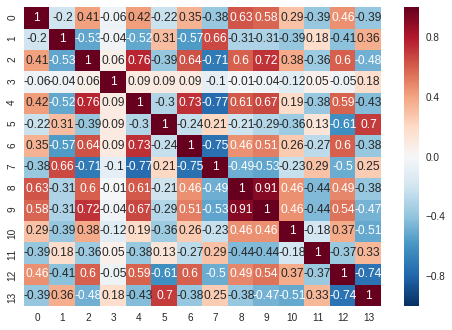

In [4]:
import seaborn as sns 
correlation_matrix = dataframe.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

The correlation coefficient ranges from -1 to 1. If the value is close to 1, it means that there is a strong positive correlation between the two variables. 

To fit a linear regression model, we select those features which have a high correlation with our target variable MEDV. 
By looking at the correlation matrix we can see that RM has a strong positive correlation with MEDV (0.7) where as LSTAT has a high negative correlation with MEDV(-0.74).

An important point in selecting features for a linear regression model is to check for multi-co-linearity. The features RAD, TAX have a correlation of 0.91. These feature pairs are strongly correlated to each other. 
Same goes for the features DIS and AGE which have a correlation of -0.75.

In [0]:
# define base mode
def baseline_model():
  # create model
  model = Sequential()
  model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer="normal"))
  # Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

It is a simple model that has a single fully connected hidden layer with the same number of neurons as input attributes (13). 

No activation function is used for the output layer because it is a regression problem and we are interested in predicting numerical values directly without transform.

The e cient ADAM optimization algorithm is used and a mean squared error loss function is optimized.

In [0]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

The Keras wrapper object for use in scikit-learn as a regression estimator is called KerasRegressor.

###The final step is to evaluate this baseline model. 

In [7]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -114.55 (82.69) MSE


When I looked into this, I found that the now-depreciated sklearn.cross_validation is apparently supposed to return a negative MSE, based on the idea that greater numbers always indicate better results. See here for a discussion among the developers, especially this comment for a particularly unintuitive result. It's also worth nothing that sklearn.metrics.make_scorer takes a greater_is_better flag that lets the user customize this.

However, the non-depreciated sklearn.model_selection.cross_val_score is not negating MSE, including when I run it. My guess was that the Keras wrapper was messing things up by negating the no-longer-negated MSE, but I can't find any documentation or anything in the Keras code to that effect, and somehow Paddy is running your code and getting the correct result. I tried it again with scikit-learn (0.19.1) and tensorflow (1.4.0), and it's still negative.

So unfortunately my recommendation is to accept that the actual MSE is the negation of what you're getting, or to build your model without Keras and see if that works. You could also try raising an issue with the Keras devs on GitHub.

### 12.3 Lift Performance By Standardizing The Dataset
An important concern with the Boston house price dataset is that the input attributes all vary in their scales because they measure different quantities. 

In [10]:
# evaluate model with standardized dataset
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, nb_epoch=50,
    batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -567.33 (277.53) MSE


### Without cross-validation

In [12]:
model = Sequential()
model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal')) 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=150, batch_size=10)

Epoch 1/150
506/506 [==============================] - 1s 1ms/step - loss: 240.9171
Epoch 2/150
506/506 [==============================] - 0s 128us/step - loss: 86.5753
Epoch 3/150
506/506 [==============================] - 0s 128us/step - loss: 73.3497
Epoch 4/150
506/506 [==============================] - 0s 136us/step - loss: 66.9111
Epoch 5/150
506/506 [==============================] - 0s 129us/step - loss: 64.5375
Epoch 6/150
506/506 [==============================] - 0s 118us/step - loss: 62.9937
Epoch 7/150
506/506 [==============================] - 0s 133us/step - loss: 61.0464
Epoch 8/150
506/506 [==============================] - 0s 134us/step - loss: 59.5822
Epoch 9/150
506/506 [==============================] - 0s 129us/step - loss: 58.7405
Epoch 10/150
506/506 [==============================] - 0s 135us/step - loss: 57.3071
Epoch 11/150
506/506 [==============================] - 0s 124us/step - loss: 56.1014
Epoch 12/150
506/506 [==============================] - 0s 131us

In [13]:
model.evaluate(X, Y)

506/506 [==============================] - 0s 609us/step


16.811669425059684